### Installing and importing useful libraries

In [1]:
# Standard libraries
import os
import sys
import math
import random
import datetime
import itertools

# Numerical computing
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_theme()

#importing optimization techniques
from implementations import *
from helpers import *

### Importing data

In [2]:

base_path = os.path.join("data", "dataset")

# File paths
x_train_path = os.path.join(base_path, "X_train_ohe_pca_aug.csv")
y_train_path = os.path.join(base_path, "y_train.csv")

# Load the data
x_train = np.loadtxt(x_train_path, delimiter=',', dtype=float, skiprows=1)
y_train = np.loadtxt(y_train_path, delimiter=',', dtype=float, skiprows=1, usecols=1)

# Convert y_train from {-1, 1} to {0, 1}
y_train = np.where(y_train == -1, 0, y_train)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)



x_train shape: (656270, 439)
y_train shape: (328135,)


In [3]:
AUGMENTATION_FACTOR = 1

# 2. Augment the target array (y_train)
# Since the factor was 1, we stack the original y_train with itself once.
# np.concatenate works well for 1D or 2D arrays.
y_train_augmented = np.concatenate([y_train] * (AUGMENTATION_FACTOR + 1), axis=0)

# Check to confirm the sizes match before passing to the function
# This check will now pass:
# x_train.shape should be (656270, M)
# y_train_augmented.shape should be (656270,) or (656270, 1)
print(f"Augmented X shape: {x_train.shape[0]} rows")
print(f"Augmented Y shape: {y_train_augmented.shape[0]} rows")

Augmented X shape: 656270 rows
Augmented Y shape: 656270 rows


### Splitting the data between 20 % validation set and 80 % training set

In [4]:
def train_val_split(X, y, val_ratio=0.20, seed=42):
    '''
    Function to randomly split the data in a 20% validation set and a 80% training set
    Args : 
            - X (numpy array) dataset input
            - y (numpy array) dataset output
            - val_ratio (float) validation set percentage, default 20%
            - seed (int) random seed
    Returns : 
            - Input train set, input validation set, output train set, output validation set, train indices, validation indices
    '''
    X = np.asarray(X); y = np.asarray(y)
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_val = int(np.round(n * val_ratio))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    return X[train_idx], X[val_idx], y[train_idx], y[val_idx], train_idx, val_idx


# split dataset in validation and train set
x_train_split, x_val_split, y_train_split, y_val_split, tr_idx, va_idx = train_val_split(x_train, y_train_augmented, val_ratio=0.20, seed=42)
print(x_train_split.shape)
print(x_val_split.shape)


(525016, 439)
(131254, 439)


### Metrics

In [5]:


def compute_auc(y_true, y_scores):
    """
    AUC calculation using Mann-Whitney statistics
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            AUC Area under the ROC curve 
    """
    order = np.argsort(y_scores)
    y_true_sorted = y_true[order]

    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos

    # rank positions 
    rank_positions = np.arange(1, len(y_true_sorted) + 1)
    rank_sum = np.sum(rank_positions[y_true_sorted == 1])

    # AUC using Mann–Whitney
    auc = (rank_sum - n_pos*(n_pos+1)/2) / (n_pos * n_neg)
    return auc

def compute_accuracy(y_true, y_scores) : 
    """
    Accuracy computation
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            Accuracy = correct predictions / total predictions %

    """
    correct_pred = (y_true == y_scores)
    accuracy = np.mean(correct_pred) * 100
    return accuracy

def compute_F1(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)
    # Precision: how many predicted positives are true
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Recall: how many true positives were found
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1-score: harmonic mean of precision and recall
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return F1, precision, recall
    


### Functions to balance data

In [6]:
# BALANCING DATA BY UNDERSAMPLING

def undersample(y_train, seed=21):
    """Restituisce solo gli indici per un dataset bilanciato via undersampling."""
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj = classes[np.argmax(counts)]
    min_ = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj)
    min_idx = np.flatnonzero(y_train == min_)

    n = len(min_idx)
    sampled_maj = rng.choice(maj_idx, size=n, replace=False)
    balanced_idx = np.concatenate((sampled_maj, min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx

#BALANCING DATA BY OVERSAMPLING
def oversample(y_train, seed=21):
    """Function to implement balancing of the dataset using oversampling of the minority class
    Inputs : 
            - y_train : (numpy array) output train datatset
            - seed : (int) randomization seed
    """
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj_class = classes[np.argmax(counts)]
    min_class = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj_class)
    min_idx = np.flatnonzero(y_train == min_class)

    # sample minority indexes to be equal to the majority class
    sampled_min_idx = rng.choice(min_idx, size=len(maj_idx), replace=True)
    balanced_idx = np.concatenate((maj_idx, sampled_min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx


### K-fold cross validation with oversampling and undersampling dataset for linear regression models

In [7]:
import implementations
import importlib
importlib.reload(implementations)
from implementations import *


def build_k_indices(N, k_fold, seed=21): 
    """build k indices for k-fold. 
        Args: N: num of samples 
              k_fold: K in K-fold, i.e. the fold num 
              seed: the random seed 
        Returns: 
              A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold 
    """
    num_row = N 
    interval = int(num_row / k_fold) 
    np.random.seed(seed) 
    indices = np.random.permutation(num_row) 
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)] 
    return np.array(k_indices)

w_initial, _ = ridge_regression(y_train_split, x_train_split, lambda_=0.001) # to make the k-cross faster, we start by a better guess


import gc

def k_fold_cross_validation(
    y_train, x_train, lambdas, gammas, max_iters,
    k_fold, methods, w_initial, seed,
    undersampling=False, oversampling=True
):
    """
    Memory-safe k-fold cross-validation for linear models.
    Oversampling/undersampling done via indices, no full array duplication.
    """

    # Build stratified folds 
    N = len(y_train)
    k_indices = build_k_indices(N, k_fold, seed)
    

    # Prepare folds 
    fold_index_pairs=[]
    for k in range(k_fold):
        test_idx = k_indices[k]
        mask = np.ones(N, dtype=bool); mask[test_idx] = False
        train_idx = np.flatnonzero(mask)

        y_train_k = y_train[train_idx]  
        if undersampling:
            rel_idx = undersample(y_train_k, seed)
        elif oversampling:
            rel_idx = oversample(y_train_k, seed)
        else:
            rel_idx = np.arange(len(train_idx))


        train_bal_idx = train_idx[rel_idx] 
        fold_index_pairs.append((train_bal_idx, test_idx))

    # Results containers
    best_overall = {
        "method": "", "lambda_": 0, "gamma": 0, "max_iter": 0,
        "train_loss": 0, "test_loss": 0, "AUC": 0,
        "F1_score": 0, "accuracy": 0
    }
    results = []

    # Define which hyperparameters matter per method
    method_params = {
        "ridge_regression": ["lambda_"],
        "least_squares": [],
        "mean_squared_error_sgd": ["gamma", "max_iter"],
    }

    # Grid search per method
    for method in methods:
        params = method_params[method]
        best_per_method = best_overall.copy()
        best_per_method["method"] = method

        lam_space = lambdas if "lambda_" in params else [0]
        gam_space = gammas if "gamma" in params else [0]
        iter_space = max_iters if "max_iter" in params else [1]

        for lam in lam_space:
            for gam in gam_space:
                for max_it in iter_space:
                    loss_tr, loss_te, AUCs, F1s, ACCs = [], [], [], [], []

                    # Iterate folds
                    for (train_idx_bal, test_idx) in fold_index_pairs:
                        x_train_k = x_train[train_idx_bal, :]
                        y_train_k = y_train[train_idx_bal]
                        x_test_k = x_train[test_idx, :]
                        y_test_k = y_train[test_idx]

                        # train 
                        if method == "least_squares":
                            w_opt, loss = least_squares(y_train_k, x_train_k)
                        elif method == "ridge_regression":
                            w_opt, loss = ridge_regression(y_train_k, x_train_k, lam)
                        elif method == "mean_squared_error_sgd":
                            w_opt, loss = mean_squared_error_sgd_2(
                                y_train_k, x_train_k, w_initial, max_it, gam
                            )

                        # evaluate 
                        loss_tr.append(loss)
                        loss_te.append(compute_mse_loss(y_test_k, x_test_k, w_opt))
                        y_score = x_test_k @ w_opt
                        y_pred = (y_score >= 0.5).astype(int)
                        f1, _, _ = compute_F1(y_test_k, y_pred)
                        AUCs.append(compute_auc(y_test_k, y_score))
                        ACCs.append(compute_accuracy(y_test_k, y_pred))
                        F1s.append(f1)

                        # Free fold memory
                        del x_train_k, y_train_k, x_test_k, y_test_k
                        gc.collect()

                    # mean metrics
                    mean_AUC = np.mean(AUCs)
                    if mean_AUC > best_per_method["AUC"]:
                        best_per_method.update({
                            "lambda_": lam, "gamma": gam, "max_iter": max_it,
                            "train_loss": np.mean(loss_tr),
                            "test_loss": np.mean(loss_te),
                            "AUC": mean_AUC,
                            "F1_score": np.mean(F1s),
                            "accuracy": np.mean(ACCs)
                        })
                    if mean_AUC > best_overall["AUC"]:
                        best_overall.update(best_per_method)

        results.append(best_per_method)
        print(f"{method}: best λ={best_per_method['lambda_']}, γ={best_per_method['gamma']}, "
              f"iters={best_per_method['max_iter']}, "
              f"AUC={best_per_method['AUC']:.5f}, "
              f"acc={best_per_method['accuracy']:.5f}, "
              f"F1={best_per_method['F1_score']:.5f}")

    print(f"\nBest model overall: {best_overall['method']} "
          f"(AUC={best_overall['AUC']:.5f}, acc={best_overall['accuracy']:.5f})")

    return best_overall, results

lambdas = [ 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]  # regularization parameters list
gammas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1] # step-size parameters list
max_iters = [100] # max iters list
k_folds = 5        
methods=["least_squares", "ridge_regression", "mean_squared_error_sgd" ]










In [8]:
# Validate with k-cross validation with undersampling and k_folds folds (9 min)
best_method_1, results_1 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= False, oversampling=True)

least_squares: best λ=0, γ=0, iters=1, AUC=0.85899, acc=75.70050, F1=0.37121
ridge_regression: best λ=0.0001, γ=0, iters=1, AUC=0.85904, acc=75.69631, F1=0.37119
mean_squared_error_sgd: best λ=0.0001, γ=0, iters=1, AUC=0.85904, acc=75.69631, F1=0.37119

Best model overall: ridge_regression (AUC=0.85904, acc=75.69631)


### Hyperparameters tuning 

#### Ridge regression hyperparameters tuning

In [9]:
# More precise hyperparameters tuning on the best models (3min)

def log_uniform(low, high, size):
    return 10 ** np.random.uniform(np.log10(low), np.log10(high), size)

 
# center : λ=0.0001
ridge_lambdas = log_uniform(0.5e-4, 5e-3, 15)
print("Ridge λ candidates:", ridge_lambdas)

# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 3, False, True)



Ridge λ candidates: [2.83709856e-04 6.62761135e-04 4.20157473e-04 1.62216133e-03
 5.71450617e-04 6.55094009e-05 5.50596309e-05 2.46206848e-03
 5.31893445e-04 2.40988457e-03 8.64448307e-05 1.88162174e-04
 4.95120382e-04 1.29878018e-03 2.75367380e-04]
ridge_regression: best λ=8.644483067376137e-05, γ=0, iters=1, AUC=0.85906, acc=75.68984, F1=0.37138

Best model overall: ridge_regression (AUC=0.85906, acc=75.68984)


In [10]:
# K cross ridge with center λ=8.644483067376137e-05 (2 min)
ridge_lambdas = log_uniform(3e-5, 3e-4, 10)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [7.56631280e-05 5.75591953e-05 6.97969104e-05 5.00294435e-05
 1.80238030e-04 9.43194297e-05 6.20398396e-05 2.95186075e-04
 4.17037973e-05 8.60286017e-05]
ridge_regression: best λ=9.431942965687211e-05, γ=0, iters=1, AUC=0.85904, acc=75.69555, F1=0.37117

Best model overall: ridge_regression (AUC=0.85904, acc=75.69555)


In [11]:
# K cross ridge recentered (3 min)
ridge_lambdas = log_uniform(3e-5, 3e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 3, False, True)

Ridge λ candidates: [6.05517892e-05 8.10760846e-05 1.29752983e-04 1.67033089e-04
 3.57947381e-05 3.15227406e-05 5.25118359e-05 7.58741724e-05
 8.98452972e-05 4.68176474e-05 2.94000671e-04 1.44667985e-04
 1.77646178e-04 3.79855742e-05 3.03619511e-05]


KeyboardInterrupt: 

In [12]:
best_lambda_ridge = 8.98452971546135e-05

#### Adam hyperparameters tuning 

#### Choose weights for balance classes

In [13]:

import gc
from implementations import *

  

w_neg, w_pos = compute_class_weights(y_train_split, alpha=1)
class_w = (w_neg, w_pos)
w_initial, _ = reg_logistic_regression_adam(
                y_train_split, x_train_split, 0.01, w_initial,
                100, 0.9, 0.999, 0.01, 1040, class_weights=class_w)
alphas = [1.0, 2.0, 3.0, 4.0, 5.0]
adam_lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
adam_gammas  = [1e-4, 1e-3, 1e-2, 1e-1, 1]

np.random.seed(21) 

param_tuples = [
    (
        float(np.random.choice(alphas)),
        float(np.random.choice(adam_lambdas)),
        float(np.random.choice(adam_gammas))
    )
    for _ in range(5)
]



def k_fold_cross_validation_adam(
    y_train, x_train, k_fold, param_tuples, w_initial,
    seed=21, undersampling=False, oversampling=True
):
    """
    Perform k-fold CV for Adam logistic regression with class weighting.
    param_tuples: list of tuples (alpha, lambda_, gamma, max_iter)
    """

    # build non-stratified folds (safe if oversampling)
    k_idx = build_k_indices(len(y_train), k_fold, seed)
    N = len(y_train)

    fold_index_pairs = []
    for k in range(k_fold):
        test_idx = np.asarray(k_idx[k], dtype=int)
        mask = np.ones(N, dtype=bool)
        mask[test_idx] = False
        train_idx = np.flatnonzero(mask)

        y_train_k = y_train[train_idx]
        if undersampling:
            rel_idx = undersample(y_train_k, seed)
        elif oversampling:
            rel_idx = oversample(y_train_k, seed)
        else:
            rel_idx = np.arange(len(train_idx))

        train_bal_idx = train_idx[rel_idx]
        fold_index_pairs.append((train_bal_idx, test_idx))

    # best configuration container
    best_overall = {
        "method": "adam_reg_logistic_regression",
        "alpha": 0, "lambda_": 0, "gamma": 0, 
        "train_loss": 0, "test_loss": 0, "AUC": 0,
        "F1_score": 0, "precision": 0, "recall": 0, "accuracy": 0
    }

    # loop over all parameter combinations
    for (alpha, lam, gam) in param_tuples:
        loss_tr, loss_te, AUCs, F1s, ACCs, PREs, RECs = [], [], [], [], [], [], []

        for (train_idx_bal, test_idx) in fold_index_pairs:
            x_train_k = x_train[train_idx_bal, :]
            y_train_k = y_train[train_idx_bal]
            x_test_k = x_train[test_idx, :]
            y_test_k = y_train[test_idx]

            # compute class weights for this fold
            w_neg, w_pos = compute_class_weights(y_train_k, alpha=alpha)
            class_w = (w_neg, w_pos)

            # train weighted Adam
            w_opt, loss = reg_logistic_regression_adam(
                y_train_k, x_train_k, lam, w_initial,
                100, 0.9, 0.999, gam, 1040, class_weights=class_w
            )

            # evaluate on validation
            loss_tr.append(loss)
            loss_te.append(compute_logistic_loss_weighted(y_test_k, x_test_k, w_opt))
            y_score = sigmoid(x_test_k @ w_opt)
            y_pred = (y_score >= 0.5).astype(int)

            # precision, recall, F1
            f1, precision, recall = compute_F1(y_test_k, y_pred)

            AUCs.append(compute_auc(y_test_k, y_score))
            ACCs.append(compute_accuracy(y_test_k, y_pred))
            F1s.append(f1)
            PREs.append(precision)
            RECs.append(recall)

            # free memory
            del x_train_k, y_train_k, x_test_k, y_test_k
            gc.collect()

        mean_AUC = np.mean(AUCs)
        mean_F1 = np.mean(F1s)

        if mean_AUC > best_overall["AUC"]:
            best_overall.update({
                "alpha": alpha, "lambda_": lam, "gamma": gam, 
                "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te),
                "AUC": mean_AUC, "F1_score": mean_F1,
                "precision": np.mean(PREs), "recall": np.mean(RECs),
                "accuracy": np.mean(ACCs)
            })

        print(f"α={alpha:.3f}, λ={lam:.1e}, γ={gam:.3f} "
              f"| AUC={mean_AUC:.5f} | F1={mean_F1:.5f} | "
              f"Prec={np.mean(PREs):.3f} | Rec={np.mean(RECs):.3f}")

    print("\n--- Best Adam configuration ---")
    print(f"α={best_overall['alpha']:.5f}, λ={best_overall['lambda_']:.1e}, "
          f"γ={best_overall['gamma']:.5f}")
    print(f"AUC={best_overall['AUC']:.5f}, "
          f"F1={best_overall['F1_score']:.5f}, "
          f"Prec={best_overall['precision']:.5f}, "
          f"Rec={best_overall['recall']:.5f}, "
          f"Acc={best_overall['accuracy']:.5f}")

    return best_overall


# K cross Adam (takes 2 min)
# best_overall_adam  = k_fold_cross_validation_adam(y_train_split, x_train_split, 3, param_tuples, w_initial, 21, False, False)



In [ ]:
# refine the tuning  (takes too long)
alphas = [0.5, 1, 1.25, 1.5, 1.75,]
adam_lambdas = [1e-4, 1e-3, 1e-2]
adam_gammas  = [1e-4, 1e-3, 1e-2]


candidates_refine = list(itertools.product(alphas, adam_lambdas, adam_gammas))
best_overall_adam = k_fold_cross_validation_adam(y_train_split, x_train_split, 5,
                                        candidates_refine, w_initial,
                                        seed=3, undersampling=False, oversampling=False)

α=0.500, λ=1.0e-04, γ=0.000 | AUC=0.85324 | F1=0.39939 | Prec=0.283 | Rec=0.680
α=0.500, λ=1.0e-04, γ=0.001 | AUC=0.85457 | F1=0.41288 | Prec=0.311 | Rec=0.616
α=0.500, λ=1.0e-04, γ=0.010 | AUC=0.85577 | F1=0.41293 | Prec=0.305 | Rec=0.640
α=0.500, λ=1.0e-03, γ=0.000 | AUC=0.85325 | F1=0.39914 | Prec=0.282 | Rec=0.680
α=0.500, λ=1.0e-03, γ=0.001 | AUC=0.85461 | F1=0.41286 | Prec=0.312 | Rec=0.611
α=0.500, λ=1.0e-03, γ=0.010 | AUC=0.85600 | F1=0.41487 | Prec=0.317 | Rec=0.606
α=0.500, λ=1.0e-02, γ=0.000 | AUC=0.85323 | F1=0.39914 | Prec=0.283 | Rec=0.679
α=0.500, λ=1.0e-02, γ=0.001 | AUC=0.85399 | F1=0.41345 | Prec=0.314 | Rec=0.604
α=0.500, λ=1.0e-02, γ=0.010 | AUC=0.85182 | F1=0.40517 | Prec=0.300 | Rec=0.626
α=1.000, λ=1.0e-04, γ=0.000 | AUC=0.85274 | F1=0.36589 | Prec=0.237 | Rec=0.798
α=1.000, λ=1.0e-04, γ=0.001 | AUC=0.85387 | F1=0.36406 | Prec=0.235 | Rec=0.811
α=1.000, λ=1.0e-04, γ=0.010 | AUC=0.85526 | F1=0.37344 | Prec=0.244 | Rec=0.794
α=1.000, λ=1.0e-03, γ=0.000 | AUC=0.8527

In [14]:
# choose the best for each alpha wrt AUC
# alpha = 0.5
best_alpha_1 = 0.5
best_lambda_1 = 1e-4
best_gamma_1 = 0.010

# alpha = 0
best_alpha_2 = 1
best_lambda_2 = 1e-3
best_gamma_2 = 0.010

# alpha = 1.25
best_alpha_3 = 1.25
best_lambda_3 = 1e-3
best_gamma_3 = 0.010

# alpha = 1.5
best_alpha_4 = 1.5
best_lambda_4 = 1e-3
best_gamma_4 = 0.010

# alpha = 1.75
best_alpha_5 = 1.75
best_lambda_5 = 1e-3
best_gamma_5 = 0.010

'''# alpha = 2
best_alpha_6 = 2.0
best_lambda_6 = 1e-3
best_gamma_6 = 0.010

# alpha = 2.25
best_alpha_7 = 2.25
best_lambda_7 = 1e-3
best_gamma_7 = 0.010
'''



'# alpha = 2\nbest_alpha_6 = 2.0\nbest_lambda_6 = 1e-3\nbest_gamma_6 = 0.010\n\n# alpha = 2.25\nbest_alpha_7 = 2.25\nbest_lambda_7 = 1e-3\nbest_gamma_7 = 0.010\n'

### Find the best threshold

In [15]:
# Define k cross validation function to find the best threshold per method
import numpy as np
import gc
def compute_F1_th(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)
    # Precision: how many predicted positives are true
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Recall: how many true positives were found
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1-score: harmonic mean of precision and recall
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return F1

def k_fold_cross_validation_threshold(method, y_train, x_train, k_fold, param_tuple, w_initial,
                                      seeds, undersampling=False, oversampling=False):
    """Find best decision threshold for F1 using multiple seeds and k-fold CV."""
    x_train = x_train.astype(np.float32, copy=False)
    alpha, lam, gam, = param_tuple
    seed_results = []  # store results for each seed

    for seed in seeds:
        k_idx = build_k_indices(len(y_train), k_fold, int(seed))
        N = len(y_train)
        fold_index_pairs = []

        for k in range(k_fold):
            test_idx = k_idx[k]
            mask = np.ones(N, dtype=bool)
            mask[test_idx] = False
            train_idx = np.flatnonzero(mask)

            y_train_k = y_train[train_idx]
            if undersampling:
                rel_idx = undersample(y_train_k, int(seed))
            elif oversampling:
                rel_idx = oversample(y_train_k, int(seed))
            else:
                rel_idx = np.arange(len(train_idx))

            train_bal_idx = train_idx[rel_idx]
            fold_index_pairs.append((train_bal_idx, test_idx))

        F1, accuracies, t_stars, AUC = [], [], [], []

        for (train_idx_bal, test_idx) in fold_index_pairs:
            x_train_k = x_train[train_idx_bal, :]
            y_train_k = y_train[train_idx_bal]
            x_test_k = x_train[test_idx, :]
            y_test_k = y_train[test_idx]

            if method == "adam_reg_logistic_regression":
                w_neg, w_pos = compute_class_weights(y_train_k, alpha=alpha)
                class_w = (w_neg, w_pos)

                # train weighted Adam
                w_opt, _ = reg_logistic_regression_adam(
                y_train_k, x_train_k, lam, w_initial,
                100, 0.9, 0.999, gam, 1040, class_weights=class_w
            )

                y_score = sigmoid(x_test_k @ w_opt)
            else:  # ridge
                w_opt, _ = ridge_regression(y_train_k, x_train_k, lam)
                y_score = x_test_k @ w_opt

            thresholds = np.linspace(0.1, 0.9, 100)
            f1s = [compute_F1_th(y_test_k, (y_score >= t).astype(int)) for t in thresholds]
            t_star = thresholds[np.argmax(f1s)]
            best_f1 = np.max(f1s)

            y_pred = (y_score >= t_star).astype(int)
            AUC.append(compute_auc(y_test_k, y_score))
            accuracies.append(compute_accuracy(y_test_k, y_pred))
            F1.append(best_f1)
            t_stars.append(t_star)

            del x_train_k, y_train_k, x_test_k, y_test_k
            gc.collect()

        # per-seed mean
        seed_results.append({
            "seed": int(seed),
            "threshold": float(np.mean(t_stars)),
            "AUC": float(np.mean(AUC)),
            "F1": float(np.mean(F1)),
            "accuracy": float(np.mean(accuracies))
        })

    # aggregate over seeds
    best_threshold = np.mean([r["threshold"] for r in seed_results])
    AUC_mean = np.mean([r["AUC"] for r in seed_results])
    F1_mean = np.mean([r["F1"] for r in seed_results])
    accuracy_mean = np.mean([r["accuracy"] for r in seed_results])

    print(f"\nResults per seed:")
    for r in seed_results:
        print(f" seed={r['seed']:3d} | thr={r['threshold']:.4f} | AUC={r['AUC']:.4f} | "
              f"F1={r['F1']:.4f} | acc={r['accuracy']:.4f}")

    print(f"\nMean results for {method}: thr={best_threshold:.5f} | "
          f"AUC={AUC_mean:.5f} | F1={F1_mean:.5f} | acc={accuracy_mean:.5f}")

    return best_threshold, AUC_mean, F1_mean, accuracy_mean, seed_results

seeds = np.arange(1, 101, 100)  


In [16]:
# Find the best threshold for Adam with hyperparamters found through tuning
# alpha 1
w_initial , _ = least_squares(y_train_split, x_train_split)
best_threshold_adam_1 , _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_1, best_lambda_1, best_gamma_2 ), w_initial, seeds, False, False )

# alpha 2
best_threshold_adam_2, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_2, best_lambda_2, best_gamma_2 ), w_initial, seeds, False, False )

# alpha 3
best_threshold_adam_3, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_3, best_lambda_3, best_gamma_3 ), w_initial, seeds, False, False )

# alpha 4
best_threshold_adam_4, _, _, _,_ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_4, best_lambda_4, best_gamma_4 ), w_initial, seeds, False, False )

# alpha 5
best_threshold_adam_5, _, _, _,_ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_5, best_lambda_5, best_gamma_5 ), w_initial, seeds, False, False )
'''
# alpha 6
best_threshold_adam_6, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_6, best_lambda_6, best_gamma_6 ), w_initial, seeds, False, False )

# alpha 7
best_threshold_adam_7, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_7, best_lambda_7, best_gamma_7 ), w_initial, seeds, False, False )
'''


Results per seed:
 seed=  1 | thr=0.5509 | AUC=0.8521 | F1=0.4131 | acc=85.6318

Mean results for adam_reg_logistic_regression: thr=0.55091 | AUC=0.85206 | F1=0.41311 | acc=85.63184

Results per seed:
 seed=  1 | thr=0.7190 | AUC=0.8533 | F1=0.4150 | acc=86.2583

Mean results for adam_reg_logistic_regression: thr=0.71899 | AUC=0.85329 | F1=0.41501 | acc=86.25830

Results per seed:
 seed=  1 | thr=0.7642 | AUC=0.8530 | F1=0.4146 | acc=86.3027

Mean results for adam_reg_logistic_regression: thr=0.76424 | AUC=0.85304 | F1=0.41458 | acc=86.30268

Results per seed:
 seed=  1 | thr=0.7901 | AUC=0.8525 | F1=0.4132 | acc=85.9398

Mean results for adam_reg_logistic_regression: thr=0.79010 | AUC=0.85246 | F1=0.41316 | acc=85.93983

Results per seed:
 seed=  1 | thr=0.8111 | AUC=0.8518 | F1=0.4123 | acc=85.6433

Mean results for adam_reg_logistic_regression: thr=0.81111 | AUC=0.85183 | F1=0.41225 | acc=85.64327


'\n# alpha 6\nbest_threshold_adam_6, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_6, best_lambda_6, best_gamma_6 ), w_initial, seeds, False, False )\n\n# alpha 7\nbest_threshold_adam_7, _, _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (best_alpha_7, best_lambda_7, best_gamma_7 ), w_initial, seeds, False, False )\n'

In [17]:
best_threshold_adam = 0.7190
best_alpha_adam =best_alpha_2
best_lambda_adam = best_lambda_2 
best_gamma_adam = best_gamma_2 

In [18]:
# Find the best threshold for Ridge with hyperparamters found through tuning
best_threshold_ridge , _, _ , _ , _= k_fold_cross_validation_threshold("ridge_regression", y_train_split, x_train_split, 10, (0, best_lambda_ridge, 0), w_initial, seeds, False, True )


Results per seed:
 seed=  1 | thr=0.6729 | AUC=0.8591 | F1=0.4286 | acc=86.9294

Mean results for ridge_regression: thr=0.67293 | AUC=0.85909 | F1=0.42859 | acc=86.92939


### Find w_opt, with best hyperparameters

In [19]:
# find w_opt_adam with k cross validation

import numpy as np
import gc

def compute_F1(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)
    # Precision: how many predicted positives are true
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Recall: how many true positives were found
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1-score: harmonic mean of precision and recall
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return F1, precision, recall

def k_fold_cross_validation_models(
    y_train, x_train, k_fold, method, params, w_initial,
    seed=21, undersampling=False, oversampling=False
):
    """
    K-fold CV for ridge or Adam logistic regression.

    Args:
        y_train, x_train : np.ndarray
        k_fold : int
        method : str ("ridge_regression" or "adam_reg_logistic_regression")
        params : tuple (alpha, lambda_, gamma)
        w_initial : np.ndarray
        seed : int
        undersampling, oversampling : bool

    Returns:
        results : dict containing averaged metrics and mean w_opt
    """

    # unpack parameters
    alpha, lam, gam = params

    # build folds
    k_idx = build_k_indices(len(y_train), k_fold, seed)
    N = len(y_train)

    # storage
    w_list, AUCs, F1s, ACCs, PREs, RECs, train_losses, test_losses = [], [], [], [], [], [], [], []

    for k in range(k_fold):
        test_idx = np.asarray(k_idx[k], dtype=int)
        mask = np.ones(N, dtype=bool)
        mask[test_idx] = False
        train_idx = np.flatnonzero(mask)

        y_test_k, x_test_k = y_train[test_idx], x_train[test_idx]
        y_train_k, x_train_k = y_train[train_idx], x_train[train_idx]

        # balance data if needed
        if undersampling:
            idx_bal = undersample(y_train_k, seed)
        elif oversampling:
            idx_bal = oversample(y_train_k, seed)
        else:
            idx_bal = np.arange(len(y_train_k))

        x_train_k = np.take(x_train_k, idx_bal, axis=0)
        y_train_k = np.take(y_train_k, idx_bal, axis=0)

        # Train model 
        if method == "ridge_regression":
            w_opt, loss_tr = ridge_regression(y_train_k, x_train_k, lam)
            loss_te = compute_mse_loss(y_test_k, x_test_k, w_opt)
            y_score = x_test_k @ w_opt
            y_pred = (y_score >= best_threshold_ridge).astype(int)

        elif method == "adam_reg_logistic_regression":
            w_neg, w_pos = compute_class_weights(y_train_k, alpha=alpha)
            class_w = (w_neg, w_pos)

            w_opt, loss_tr = reg_logistic_regression_adam(
                y_train_k, x_train_k, lam, w_initial,
                500, 0.9, 0.999, gam, 1040, class_weights=class_w
            )
            loss_te = compute_logistic_loss_weighted(y_test_k, x_test_k, w_opt)
            y_score = sigmoid(x_test_k @ w_opt)
            y_pred = (y_score >= best_threshold_adam).astype(int)

        else:
            raise ValueError(f"Unsupported method: {method}")

        #  Evaluate
        f1, prec, rec = compute_F1(y_test_k, y_pred)
        auc = compute_auc(y_test_k, y_score)
        acc = compute_accuracy(y_test_k, y_pred)

        # store
        w_list.append(w_opt)
        train_losses.append(loss_tr)
        test_losses.append(loss_te)
        F1s.append(f1)
        PREs.append(prec)
        RECs.append(rec)
        AUCs.append(auc)
        ACCs.append(acc)

        del x_train_k, y_train_k, x_test_k, y_test_k
        gc.collect()

    # Compute mean metrics 
    results = {
        "method": method,
        "mean_w": np.mean(np.vstack(w_list), axis=0),
        "train_loss": np.mean(train_losses),
        "test_loss": np.mean(test_losses),
        "AUC": np.mean(AUCs),
        "F1_score": np.mean(F1s),
        "precision": np.mean(PREs),
        "recall": np.mean(RECs),
        "accuracy": np.mean(ACCs),
    }

    print(f"\n=== {method.upper()} (averaged over {k_fold} folds) ===")
    print(f"α={alpha:.3f}, λ={lam:.1e}, γ={gam:.3f}")
    print(f"AUC={results['AUC']:.5f} | F1={results['F1_score']:.5f} | "
          f"Prec={results['precision']:.3f} | Rec={results['recall']:.3f} | "
          f"Acc={results['accuracy']:.3f}")

    return results




In [20]:
results_adam = k_fold_cross_validation_models(y_train_split, x_train_split, 5, "adam_reg_logistic_regression", (best_alpha_adam, best_lambda_adam, best_gamma_adam), w_initial, 21, False, False)

w_opt_adam = results_adam["mean_w"]


=== ADAM_REG_LOGISTIC_REGRESSION (averaged over 5 folds) ===
α=1.000, λ=1.0e-03, γ=0.010
AUC=0.85748 | F1=0.42214 | Prec=0.341 | Rec=0.558 | Acc=86.451


In [21]:
w_opt_adam = np.array(w_opt_adam)

In [22]:
results_ridge = k_fold_cross_validation_models(y_train_split, x_train_split, 5, "ridge_regression", (0, best_lambda_ridge, 0), w_initial, 21, False, True)

w_opt_ridge = np.array(results_ridge["mean_w"])


=== RIDGE_REGRESSION (averaged over 5 folds) ===
α=0.000, λ=9.0e-05, γ=0.000
AUC=0.85904 | F1=0.42752 | Prec=0.349 | Rec=0.552 | Acc=86.915


### Validation on our validation sample

In [57]:

# Define validation function
def validation(w_opt, x_val, y_val, method, threshold): 
    if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val @ w_opt) 
    else:
        y_score = x_val @ w_opt
    y_pred = np.where(y_score >=threshold, 1, 0) 
    AUC = compute_auc(y_val, y_score)
    accuracy = compute_accuracy(y_val, y_pred)
    F1, _, _ = compute_F1(y_val, y_pred)

    return AUC, accuracy, F1

 

# Retrain optimal models on the whole validation dataset

# Ridge regression
method = "ridge_regression"

# validate
AUC, accuracy, F1 = validation(w_opt_ridge, x_val_split, y_val_split,method,  best_threshold_ridge)
print(f"the method ridge regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

# Adam 
method = "adam_reg_logistic_regression"

# validate
AUC, accuracy, F1 = validation(w_opt_adam, x_val_split, y_val_split, method, best_threshold_adam) 
print(f"the method adam_reg_logistic_regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

the method ridge regression has an accuracy = 87.25829308059183, AUC = 0.8573881128012474, F1 score = 0.4242632883503167 on our validation set
the method adam_reg_logistic_regression has an accuracy = 85.42977737821323, AUC = 0.8566322568440596, F1 score = 0.4187234042553191 on our validation set


### Visualization plot

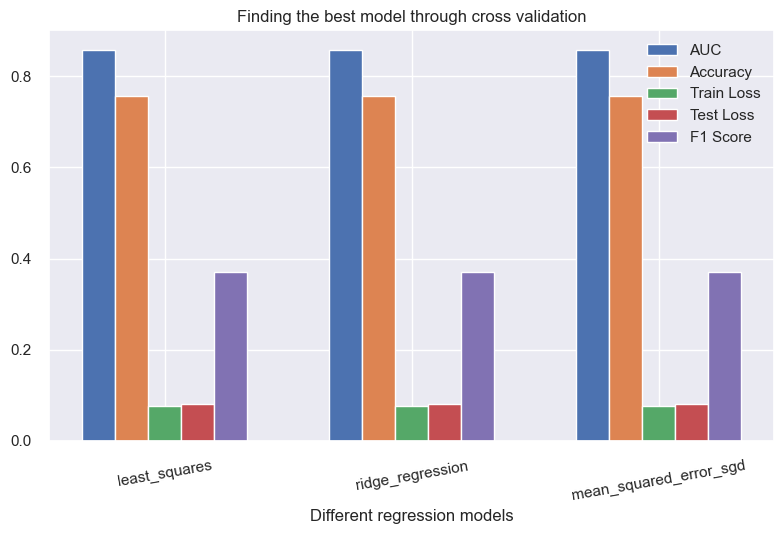

In [58]:
AUC = []
accuracy = []
loss_tr = []
loss_te = []
F1 = []

for result in results_1:
    AUC.append(result['AUC'])
    accuracy.append(result['accuracy']/100)
    loss_tr.append(result['train_loss'])
    loss_te.append(result['test_loss'])
    F1.append(result["F1_score"])

num_bars = len(results_1)
w = 0.2  
pos = np.arange(num_bars) * 1.5  

plt.bar(pos - 2*w, AUC, width=w, label='AUC')
plt.bar(pos - w, accuracy, width=w, label='Accuracy')
plt.bar(pos, loss_tr, width=w, label='Train Loss')
plt.bar(pos + w, loss_te, width=w, label='Test Loss')
plt.bar(pos + 2*w, F1, width=w, label='F1 Score')  

plt.xticks(pos, methods, rotation=10)
plt.xlabel('Different regression models')
plt.title('Finding the best model through cross validation')
plt.legend()
plt.tight_layout()
plt.show()


### Precision-recall curve and F1 vs threshold curve

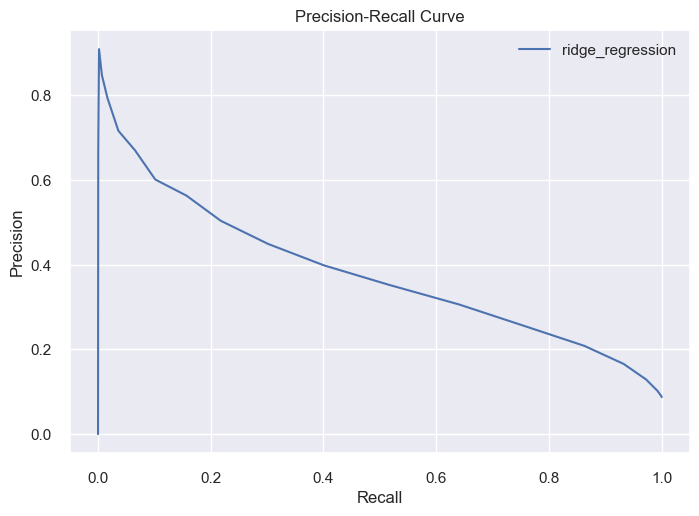

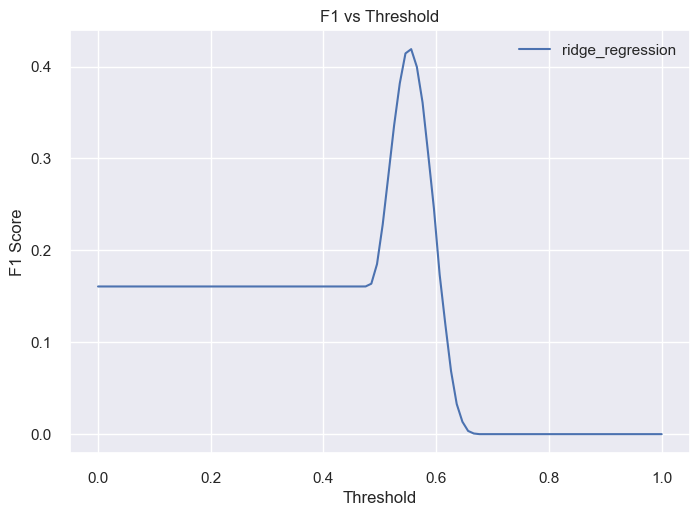

In [35]:
def plot_precision_recall(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p)
        recall.append(r)

    plt.plot(recall, precision, label=f"{method}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_f1_vs_threshold(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    F1s = [compute_F1(y_true, (y_score >= t).astype(int)) for t in thresholds]
    plt.plot(thresholds, F1s, label=f"{method}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot precision-recall curve
w_opt, _ = ridge_regression(y_val_split, x_val_split, 0.0004993 ) # use best lambda found through k-cross validation
y_score = sigmoid(x_val_split @ w_opt) 
plot_precision_recall(y_val_split, y_score, "ridge_regression")

# Plot F1 score vs threshold
plot_f1_vs_threshold(y_val_split, y_score, "ridge_regression")


### Test the model and generate the predictions

In [36]:
Xtest = np.genfromtxt("data/dataset/X_test_preprocessed.csv", delimiter=",", skip_header=1)
test_ids = Xtest[:, 0].astype(int)
print(f"Test IDs: {test_ids[:10]}")

Test IDs: [0 0 0 0 0 0 0 0 0 0]


In [24]:
import numpy as np
from helpers import create_csv_submission

# Define the prediction function 
def predict(method, X, w_opt, best_threshold):
    """
    Predict using the optimal weights and optimal threshold
    """
    if method == "ridge_regression" :
    # Ridge regression is linear: we use X @ w_opt (dot product)
        y_score = X @ w_opt  # Compute the raw predictions
    elif method == "adam_reg_logistic_regression":
        y_score = sigmoid(X @ w_opt)

    # Apply the threshold to get the final prediction
    y_pred = (y_score >= best_threshold).astype(int)
    y_pred[y_pred == 0] = -1  # Convert 0s to -1 for AIcrowd submission format
    return y_pred

def generate_submission(method, w_opt, X_test_final, best_threshold,  test_ids, out_csv="submission.csv"):
    """
    Generate the submission file using the preprocessed X_test_final and model's optimal weights (w_opt) and threshold
    """
    # Generate predictions on X_test_final using w_opt 
    y_pred = predict(method, X_test_final, w_opt, best_threshold)

    # Save the predictions in AIcrowd format
    create_csv_submission(test_ids, y_pred, out_csv)
    print(f"Saved {out_csv} | n={len(y_pred)} | {method} | dims={X_test_final.shape[1]}")

# ---- Load preprocessed X_test_final and test IDs ----
X_test_final = np.genfromtxt("data/dataset/X_test_ohe_pca_aug.csv", delimiter=",", skip_header=1)  # preprocessed test data (already in PCA space)
X_test_raw = np.genfromtxt("data/dataset/x_test.csv", delimiter=",", skip_header=1)
test_ids = X_test_raw[:, 0].astype(int)  # the first column is the ID


# ---- Call the submission function with the optimal weights ----
generate_submission("ridge_regression_pca_ohe_aug", w_opt_ridge, X_test_final,best_threshold_ridge, test_ids,  "submission_ridge_pca_ohe_aug.csv")
#generate_submission("adam_reg_logistic_regression", w_opt_adam, X_test_final,  best_threshold_adam,test_ids,  "submission_adam.csv")

UnboundLocalError: local variable 'y_score' referenced before assignment

In [25]:
import numpy as np
from helpers import create_csv_submission

# Define the prediction function
def predict(method, X, w_opt, best_threshold):
    """
    Predict using the optimal weights and optimal threshold
    """
    # NOTE: The method name in the IF must match the name passed to generate_submission
    if method.startswith("ridge_regression"):
        # Ridge regression is linear: we use X @ w_opt (dot product)
        y_score = X @ w_opt  # Compute the raw predictions
    elif method == "adam_reg_logistic_regression":
        # Ensure sigmoid function is imported or defined if this block is uncommented
        # y_score = sigmoid(X @ w_opt)
        pass
    else:
        raise ValueError(f"Unknown method {method}")

    # Apply the threshold to get the final prediction
    y_pred = (y_score >= best_threshold).astype(int)
    y_pred[y_pred == 0] = -1  # Convert 0s to -1 for AIcrowd submission format
    return y_pred

def generate_submission(method, w_opt, X_test_final, best_threshold,  test_ids, out_csv="submission.csv"):
    """
    Generate the submission file using the preprocessed X_test_final and model's optimal weights (w_opt) and threshold
    """
    # Generate predictions on X_test_final using w_opt
    y_pred = predict(method, X_test_final, w_opt, best_threshold)

    # -------------------------------------------------------------
    # CRITICAL: We only save the FIRST HALF of the predictions
    # (corresponding to the original, non-noisy test data).
    # This assumes the augmented data was stacked as [Original; Noisy Copy].
    # -------------------------------------------------------------
    N_original = len(test_ids)
    y_pred_original = y_pred[:N_original]

    # Save the predictions in AIcrowd format
    create_csv_submission(test_ids, y_pred_original, out_csv)
    print(f"Saved {out_csv} | n={len(y_pred_original)} | {method} | dims={X_test_final.shape[1]}")

# ---- Load preprocessed X_test_final and test IDs ----
X_test_final = np.genfromtxt("data/dataset/X_test_ohe_pca_aug.csv", delimiter=",", skip_header=1)  # preprocessed test data (DOUBLED ROWS)
X_test_raw = np.genfromtxt("data/dataset/x_test.csv", delimiter=",", skip_header=1)
test_ids = X_test_raw[:, 0].astype(int)  # the first column is the original IDs (ORIGINAL ROWS)

# ---- Call the submission function with the optimal weights ----
# Note: The model was trained on augmented data, but predictions are
# generated on the entire augmented test set for consistency, and then
# only the first half is saved.
generate_submission("ridge_regression_pca_ohe_aug", w_opt_ridge, X_test_final, best_threshold_ridge, test_ids, "submission_ridge_pca_ohe_aug.csv")

Saved submission_ridge_pca_ohe_aug.csv | n=109379 | ridge_regression_pca_ohe_aug | dims=439
